In [1]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [2]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages[:3]

label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...

In [3]:
messages.describe()

label                 message
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30

In [4]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [5]:
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

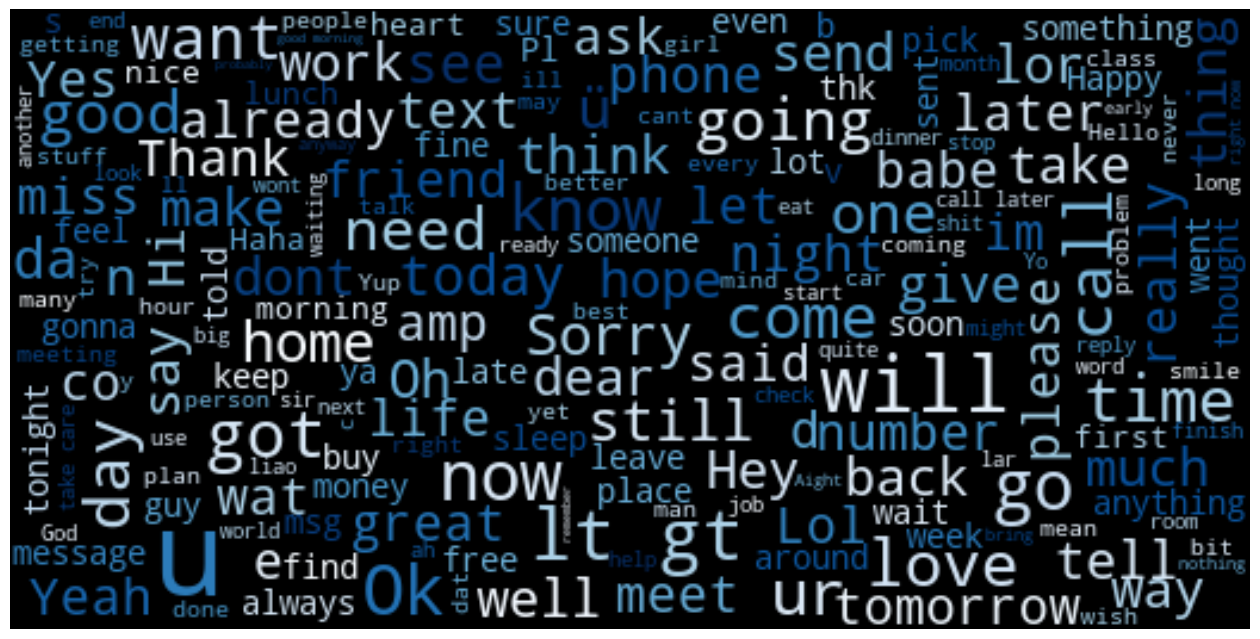

In [6]:
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

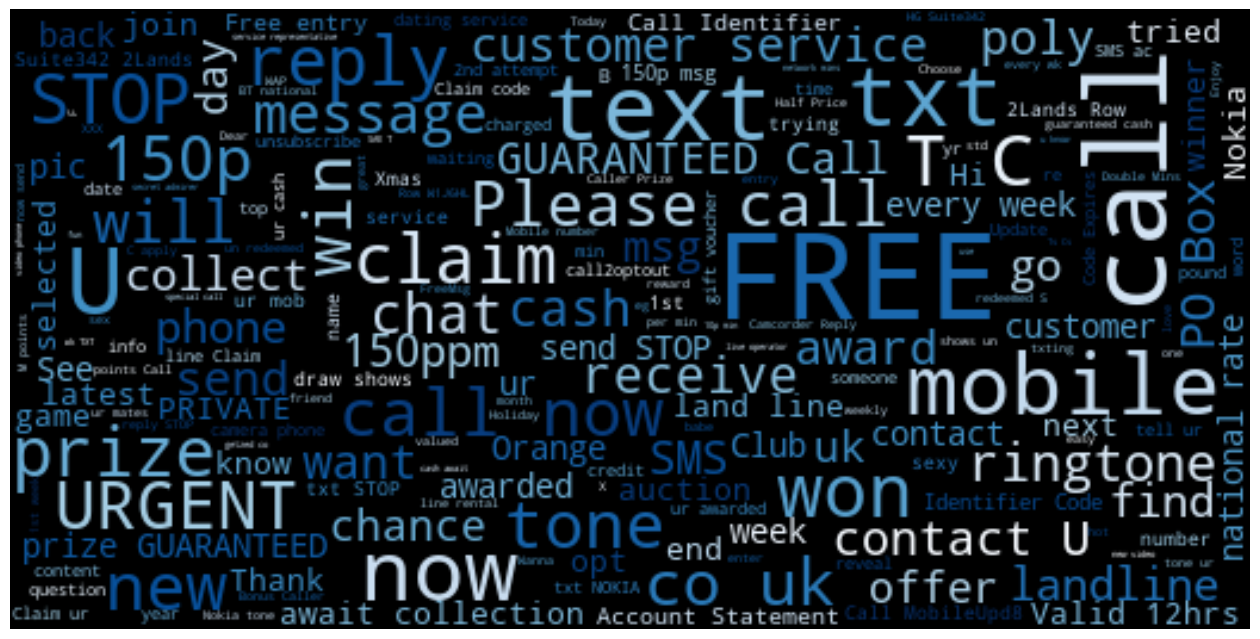

In [7]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Count')

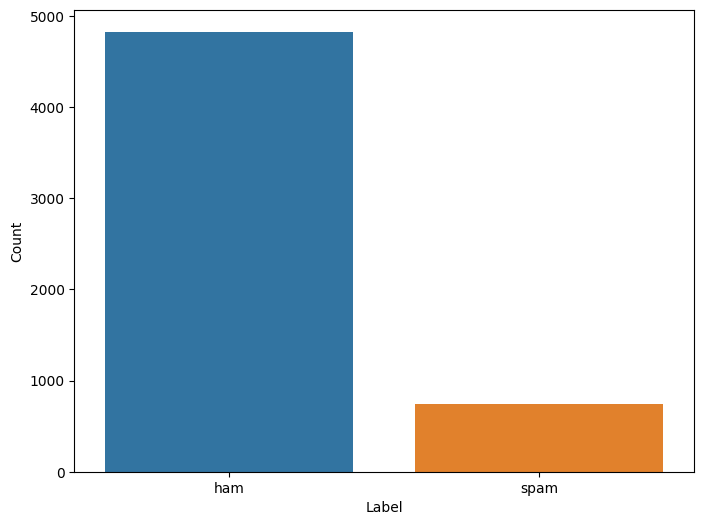

In [8]:
plt.figure(figsize=(8, 6))
sns.barplot(x=messages['label'].value_counts().index, y=messages['label'].value_counts())
plt.xlabel('Label')
plt.ylabel('Count')

In [16]:
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)


(747, 2) (747, 2)


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'Message types')

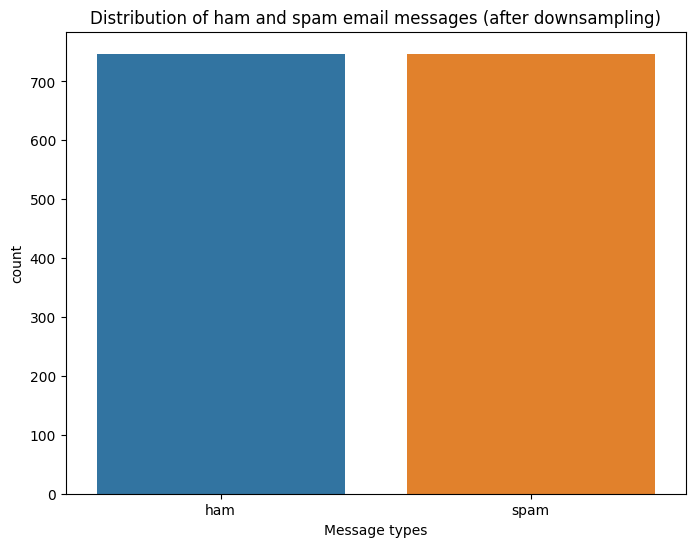

In [22]:
msg_df = pd.concat([ham_msg_df, spam_msg_df]).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(x = 'label',data = msg_df)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [23]:
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values


train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [24]:
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [32]:
word_index = tokenizer.word_index

In [33]:
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4169 unique tokens in training data. 


In [35]:
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [37]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [38]:
vocab_size = 500
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [56]:
# Dense Model
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8433 (32.94 KB)
Trainable params: 8433 (32.94 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [41]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [43]:
history = model.fit(training_padded, train_labels, epochs=40, validation_data=(testing_padded, test_labels), verbose=2)

Epoch 1/40
38/38 - 1s - loss: 0.6894 - accuracy: 0.5264 - val_loss: 0.6839 - val_accuracy: 0.6856 - 1s/epoch - 30ms/step
Epoch 2/40
38/38 - 0s - loss: 0.6691 - accuracy: 0.7456 - val_loss: 0.6588 - val_accuracy: 0.6957 - 85ms/epoch - 2ms/step
Epoch 3/40
38/38 - 0s - loss: 0.6211 - accuracy: 0.7690 - val_loss: 0.6031 - val_accuracy: 0.7960 - 83ms/epoch - 2ms/step
Epoch 4/40
38/38 - 0s - loss: 0.5431 - accuracy: 0.8460 - val_loss: 0.5199 - val_accuracy: 0.8528 - 92ms/epoch - 2ms/step
Epoch 5/40
38/38 - 0s - loss: 0.4469 - accuracy: 0.8971 - val_loss: 0.4303 - val_accuracy: 0.8796 - 92ms/epoch - 2ms/step
Epoch 6/40
38/38 - 0s - loss: 0.3528 - accuracy: 0.9188 - val_loss: 0.3465 - val_accuracy: 0.8963 - 91ms/epoch - 2ms/step
Epoch 7/40
38/38 - 0s - loss: 0.2820 - accuracy: 0.9339 - val_loss: 0.2801 - val_accuracy: 0.8997 - 84ms/epoch - 2ms/step
Epoch 8/40
38/38 - 0s - loss: 0.2317 - accuracy: 0.9498 - val_loss: 0.2336 - val_accuracy: 0.9164 - 90ms/epoch - 2ms/step
Epoch 9/40
38/38 - 0s - l

In [45]:
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 1ms/step - loss: 0.1204 - accuracy: 0.9465


[0.12038389593362808, 0.9464883208274841]

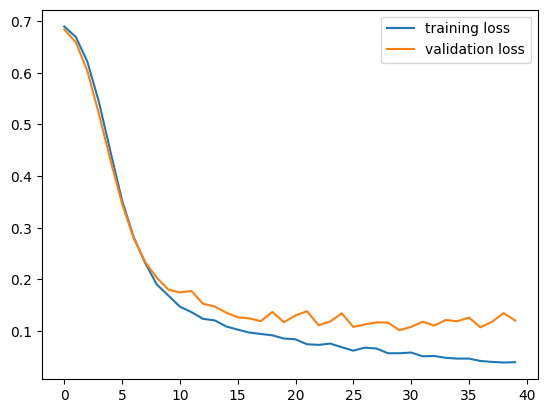

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])

In [97]:
# LSTM model
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(64, dropout=0.2, return_sequences=True))
model1.add(LSTM(64, dropout=0.2, return_sequences=True))
model1.add(LSTM(64, dropout=0.2, return_sequences=True))
model1.add(LSTM(64, dropout=0.2, return_sequences=True))
model1.add(LSTM(64, dropout=0.2, return_sequences=False))
model1.add(Dense(64,activation='relu'))
model1.add(Dense(64,activation='relu'))
model1.add(Dense(64,activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [101]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 16)            8000      
                                                                 
 lstm_19 (LSTM)              (None, 50, 64)            20736     
                                                                 
 lstm_20 (LSTM)              (None, 50, 64)            33024     
                                                                 
 lstm_21 (LSTM)              (None, 50, 64)            33024     
                                                                 
 lstm_22 (LSTM)              (None, 50, 64)            33024     
                                                                 
 lstm_23 (LSTM)              (None, 64)                33024     
                                                                 
 dense_17 (Dense)            (None, 64)               

In [104]:
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics = ['accuracy'])

In [105]:
history = model1.fit(training_padded,train_labels,validation_data=(testing_padded,test_labels),epochs= 30,callbacks=EarlyStopping(monitor='val_loss', patience=3))

Epoch 1/30
38/38 [==============================] - 15s 140ms/step - loss: 0.0802 - accuracy: 0.9824 - val_loss: 0.2133 - val_accuracy: 0.9398
Epoch 2/30
38/38 [==============================] - 3s 86ms/step - loss: 0.0489 - accuracy: 0.9900 - val_loss: 0.2349 - val_accuracy: 0.9465
Epoch 3/30
38/38 [==============================] - 3s 87ms/step - loss: 0.0426 - accuracy: 0.9908 - val_loss: 0.2008 - val_accuracy: 0.9599
Epoch 4/30
38/38 [==============================] - 3s 85ms/step - loss: 0.0328 - accuracy: 0.9925 - val_loss: 0.1871 - val_accuracy: 0.9699
Epoch 5/30
38/38 [==============================] - 3s 85ms/step - loss: 0.0479 - accuracy: 0.9883 - val_loss: 0.3216 - val_accuracy: 0.9365
Epoch 6/30
38/38 [==============================] - 3s 86ms/step - loss: 0.0326 - accuracy: 0.9941 - val_loss: 0.3208 - val_accuracy: 0.9599
Epoch 7/30
38/38 [==============================] - 3s 85ms/step - loss: 0.0477 - accuracy: 0.9891 - val_loss: 0.1712 - val_accuracy: 0.9599
Epoch 8/30


In [106]:
model1.evaluate(testing_padded,test_labels)

10/10 [==============================] - 0s 30ms/step - loss: 0.2682 - accuracy: 0.9632


[0.2682012915611267, 0.9632107019424438]

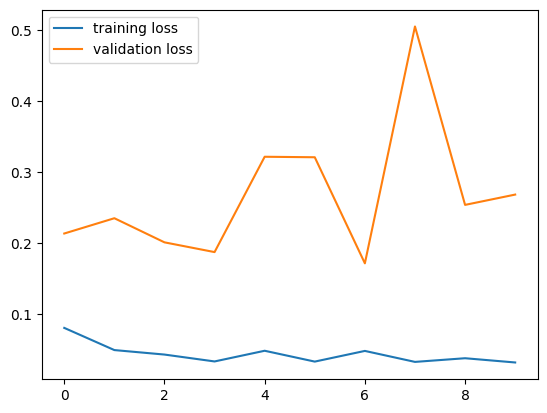

In [107]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])

In [130]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(150, dropout=0.2, return_sequences=True)))
model2.add(Bidirectional(LSTM(150,dropout=0.2,return_sequences=False)))
model2.add(Dense(128,activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [131]:
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics = ['accuracy'])

In [132]:
history = model2.fit(training_padded,train_labels,validation_data=(testing_padded,test_labels),epochs=30,callbacks=EarlyStopping(monitor='val_loss',patience=4))

Epoch 1/30
38/38 [==============================] - 29s 567ms/step - loss: 0.5591 - accuracy: 0.7013 - val_loss: 0.3891 - val_accuracy: 0.8161
Epoch 2/30
38/38 [==============================] - 14s 370ms/step - loss: 0.2103 - accuracy: 0.9197 - val_loss: 0.1875 - val_accuracy: 0.9130
Epoch 3/30
38/38 [==============================] - 18s 472ms/step - loss: 0.1303 - accuracy: 0.9540 - val_loss: 0.1139 - val_accuracy: 0.9532
Epoch 4/30
38/38 [==============================] - 15s 393ms/step - loss: 0.0942 - accuracy: 0.9682 - val_loss: 0.1248 - val_accuracy: 0.9465
Epoch 5/30
38/38 [==============================] - 11s 282ms/step - loss: 0.1066 - accuracy: 0.9615 - val_loss: 0.1276 - val_accuracy: 0.9532
Epoch 6/30
38/38 [==============================] - 11s 283ms/step - loss: 0.0714 - accuracy: 0.9749 - val_loss: 0.2647 - val_accuracy: 0.9097
Epoch 7/30
38/38 [==============================] - 11s 279ms/step - loss: 0.0585 - accuracy: 0.9824 - val_loss: 0.1405 - val_accuracy: 0.9532

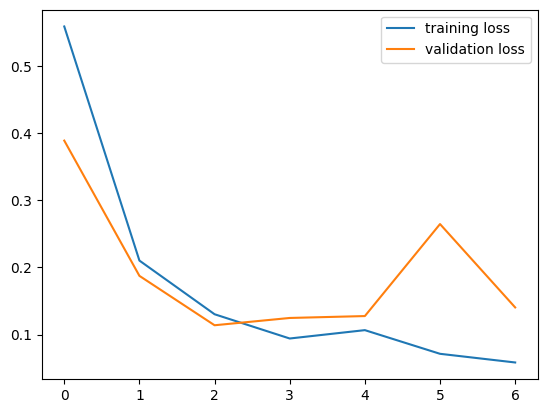

In [133]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])

In [161]:
classes = ['Ham','Spam']
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return ["Spam" if l == True else "Ham" for l in (model2.predict(padded)) > 0.5]

In [165]:
predict_spam(["""Attend a Free Online IELTS Masterclass tomorrow!ðŸŽ“ðŸŒŽ

1. Expected questions & solutions
2. Tips to score Band 7 & higher
3. Understanding Listening section accents
4. How to tackle the Speaking & Writing section
5. Analyzing complex paragraphs in Reading section

ðŸš¨ Bonus: Get 1 Month Preparation Plan """,
"""
Hey, Long time no see, How are you doing?
"""])

1/1 [==============================] - 0s 136ms/step


['Spam', 'Ham']